## Acoustic wave equation experiments in 3D (2D space + time)


from fbpinns.active_schedulers import AllActiveSchedulerND, PlaneActiveSchedulerND
from fbpinns.trainers.pinn_trainer import PINNTrainer
from fbpinns.trainers.fbpinn_trainer import FBPINNTrainer
from fbpinns.trainers_base import train_models_multiprocess
from fbpinns.common import multiprocess
from fbpinns import problems

In [62]:
import numpy as np
import torch
import torch.nn as nn

from fbpinns.problems import _Problem
from fbpinns import boundary_conditions
from fbpinns.losses import l2_loss
from fbpinns.constants import Constants, get_subdomain_ws

from fbpinns.common.utils import init_logging, get_device

init_logging()

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
device = get_device()

2024-06-07 14:00:56,600 [fbpinns.common.utils] INFO: GPU activated.


In [64]:

class WaveEquation3D(_Problem):
    """Solves the time-dependent 2D wave equation
        d^2 u   d^2 u    1  d^2 u
        ----- + ----- - --- ----- = q(x, y, t)
        dx^2    dy^2    c^2 dt^2
        
        Boundary conditions:
        u(x,y,0) = exp( -(1/2)((x/sd)^2+(y/sd)^2) )
        du
        --(x,y,0) = 0
        dt
    """
    
    @property
    def name(self):
        return f"WaveEquation3D_{self._cname}"
    
    def __init__(self, c: float = 1, source_sd: float = 0.2):
        """
        
        Parameters
        ------------
        
        c : float
            Velocity model
        
        source_sd : float
            Source standard deviation
            
        """
        
        # input params
        super().__init__()
        if isinstance(c, (float, int)):
            self.c, self._c0, self._cname = self._constant_c, c, "s%sc%s"%(source_sd,c)
        elif c == "gaussian":
            self.c, self._c0, self._cname = self._gaussian_c, 1, "s%sc%s"%(source_sd,c)
        else:
            raise Exception(f"ERROR: c input not recognised! {c}")
        self.source_sd = source_sd
        
        # dimensionality of x and y
        self.d = (3,1)

    def get_gradients(self, input_x: torch.Tensor, u: torch.Tensor) -> tuple[torch.Tensor, ...]:
        """
        Calculates the gradients required for the physics loss.
        
        Parameters
        ----------
        
        input_x : torch.Tensor
            input data - collocation points sampled across the entire domain
        u : torch.Tensor
            predicted wavefield 
        """
        
        jac =  torch.autograd.grad(u, input_x, torch.ones_like(u), create_graph=True)[0]
        
        ux, uy, ut = jac[:, 0:1], jac[:, 1:2], jac[:, 2:3]
        
        uxx = torch.autograd.grad(ux, input_x, torch.ones_like(ux), create_graph=True)[0][:, 0:1]
        uyy = torch.autograd.grad(uy, input_x, torch.ones_like(uy), create_graph=True)[0][:, 1:2]
        utt = torch.autograd.grad(ut, input_x, torch.ones_like(ut), create_graph=True)[0][:, 2:3]
        
        return u, ut, uxx, uyy, utt
    
        
    def boundary_condition(self, input_x: torch.Tensor, u, ut, uxx, uyy, utt, sd: float):
        """
        Apply hard boundary constraints, i.e. enforce our gradients and output to abide by the constraints.
        If we want a soft constraint, we can use another loss term. 
        """
        
        # u, ut, uxx, uyy, utt = uj
        
        sd = .1
        v = 1.
        t = input_x[:,2:3]
        u_new = (nn.functional.tanh(v*t/(2*sd))**2)*u # constrains u(x,y,0) = u_t(x,y,0) = 0
        return u_new, ut, uxx, uyy, utt # skip updating first order gradients (not needed for loss)
        # return u, ut, uxx, uyy, utt # skip updating first order gradients (not needed for loss)
        
        
    def physics_loss(self, input_x: torch.Tensor, *uj) -> torch.Tensor:
        """
        Calculates the physics loss
        
        Parameters
        ----------
        
        input_x : torch.Tensor
            input data - collocation points sampled across the entire domain
        u : torch.Tensor
            predicted wavefield    
        *uj : tuple[torch.Tensor, ...] 
            Derivatives, first and second order
        """
        
        u, ut, uxx, uyy, utt = uj
        physics = (uxx[:, 0] + uyy[:, 0]) - (1 / (self.c(input_x)[:, 0] ** 2)) * utt[:, 0]  # be careful to slice correctly (transposed calculations otherwise (!))
        
        x, y, t = input_x[:, 0:1], input_x[:, 1:2], input_x[:, 2:3]
        
        # ricker source term
        sd = .1
        e = -0.5*(x**2 + y**2 + t**2)/(sd**2)
        a = 2e3
        q = a * (1+e)*torch.exp(e)
        
        
        physics -= q.flatten()

        
        return l2_loss(physics, 0)

    
    def exact_solution(self, x, batch_size):
        """Devito solution can go in here"""
        y = torch.zeros((np.prod(batch_size), 1)).to(device)
        return y,y,y,y,y# skip computing analytical gradients
    
    def _gaussian(self, x, mu, sd, a):
        return a*torch.exp(-0.5*( ((x[:,0:1]-mu[0])/sd[0])**2 + ((x[:,1:2]-mu[1])/sd[1])**2) )
    
    def _constant_c(self, x):
        "Defines a constant velocity model"
        return self._c0*torch.ones((x.shape[0],1), dtype=x.dtype, device=x.device)
    
    

In [65]:
P = WaveEquation3D(c=1., source_sd=.1)

In [66]:
P.d

(3, 1)

In [67]:
runs = []

In [68]:
n_subdomains = 2
subdomain_xs = [np.linspace(-1,1,n_subdomains), np.linspace(-1,1,n_subdomains), np.linspace(0,1,n_subdomains)]
boundary_n = (0.1,)
y_n = (0,1)
batch_size = (50,50,30)
batch_size_test = (50,50,50)

n_steps = 2000
n_hidden, n_layers = 128, 3

runs = []

plot_lims = (5., True)
random = True

sampler = "m"
# runs.append(run_PINN())

In [69]:
subdomain_xs

[array([-1.,  1.]), array([-1.,  1.]), array([0., 1.])]

In [70]:
cpinn = Constants(
              RUN="final_PINN_%s_%sh_%sl_%sb_%s"%(P.name, n_hidden, n_layers, batch_size[0], sampler),
              P=P,
              SUBDOMAIN_XS=subdomain_xs,
              BOUNDARY_N=boundary_n,
              Y_N=y_n,
              N_HIDDEN=n_hidden,
              N_LAYERS=n_layers,
              BATCH_SIZE=batch_size,
              RANDOM=random,
              N_STEPS=n_steps,
              BATCH_SIZE_TEST=batch_size_test,
              PLOT_LIMS=plot_lims,
              )

In [71]:
from fbpinns.trainers.pinn_trainer import PINNTrainer
cpinn.TEST_FREQ = 1000
trainer = PINNTrainer(c=cpinn)

2024-06-07 14:00:56,721 [fbpinns.trainers_base] INFO: RUN: final_PINN_WaveEquation3D_s0.1c1.0_128h_3l_50b_m
P: <__main__.WaveEquation3D object at 0x70783e434090>
SUBDOMAIN_XS: [array([-1.,  1.]), array([-1.,  1.]), array([0., 1.])]
SUBDOMAIN_WS: [array([1.25663706e+10, 1.25663706e+10, 1.25663706e+10, 1.25663706e+10,
       1.25663706e+10, 1.25663706e+10])]
BOUNDARY_N: (0.1,)
Y_N: (0, 1)
ACTIVE_SCHEDULER: <class 'fbpinns.active_schedulers.PointActiveSchedulerND'>
ACTIVE_SCHEDULER_ARGS: (array([0]),)
DEVICE: 0
MODEL: <class 'fbpinns.models.FCN'>
N_HIDDEN: 128
N_LAYERS: 3
BATCH_SIZE: (50, 50, 30)
RANDOM: True
LRATE: 0.001
N_STEPS: 2000
SEED: 123
BATCH_SIZE_TEST: (50, 50, 50)
PLOT_LIMS: (5.0, True)
SUMMARY_FREQ: 250
TEST_FREQ: 1000
MODEL_SAVE_FREQ: 10000
SHOW_FIGURES: True
SAVE_FIGURES: False
CLEAR_OUTPUT: False
SUMMARY_OUT_DIR: results/summaries/final_PINN_WaveEquation3D_s0.1c1.0_128h_3l_50b_m/
MODEL_OUT_DIR: results/models/final_PINN_WaveEquation3D_s0.1c1.0_128h_3l_50b_m/
HOSTNAME: bened

2024-06-07 14:00:56,744 [fbpinns.trainers.pinn_trainer] INFO: tensor([0.0000, 0.0000, 0.5000], device='cuda:0'), tensor([1.0000, 1.0000, 0.5000], device='cuda:0'), torch.Size([3]), torch.Size([3])


[i: 250/2000] loss: 21.7253 rate: 21.4 elapsed: 0.00 hr 2024-06-07 13:01:08 final_PINN_WaveEquation3D_s0.1c1.0_128h_3l_50b_m
[i: 500/2000] loss: 4.1693 rate: 21.3 elapsed: 0.01 hr 2024-06-07 13:01:20 final_PINN_WaveEquation3D_s0.1c1.0_128h_3l_50b_m
[i: 750/2000] loss: 1.6416 rate: 21.4 elapsed: 0.01 hr 2024-06-07 13:01:31 final_PINN_WaveEquation3D_s0.1c1.0_128h_3l_50b_m
[i: 1000/2000] loss: 1.0204 rate: 21.6 elapsed: 0.01 hr 2024-06-07 13:01:43 final_PINN_WaveEquation3D_s0.1c1.0_128h_3l_50b_m


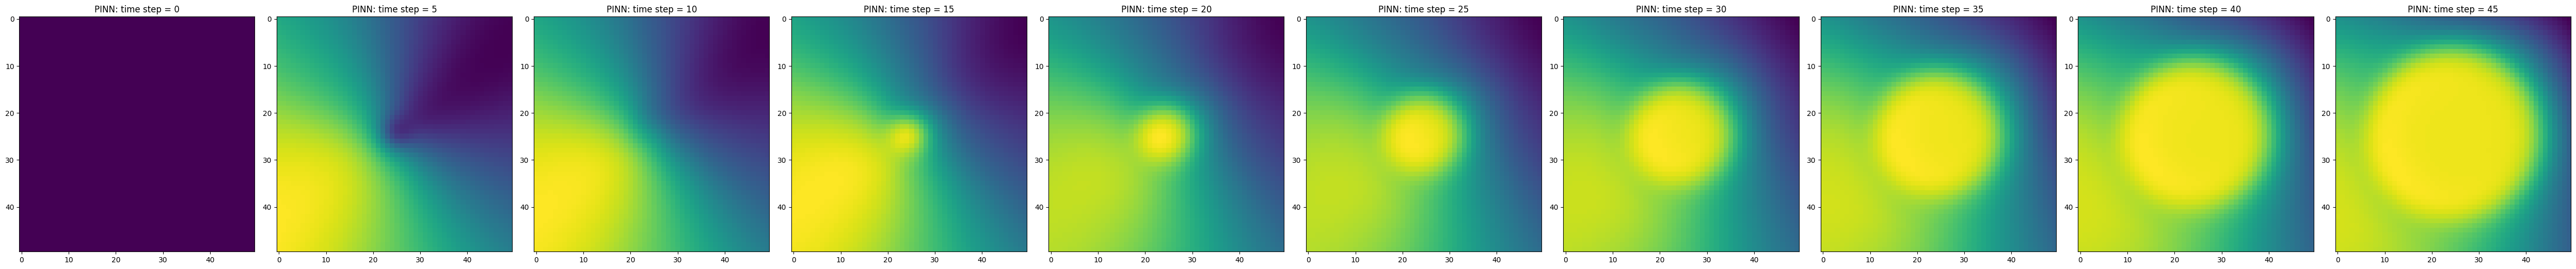

[i: 1250/2000] loss: 0.5958 rate: 21.7 elapsed: 0.02 hr 2024-06-07 13:01:55 final_PINN_WaveEquation3D_s0.1c1.0_128h_3l_50b_m
[i: 1500/2000] loss: 0.4982 rate: 21.3 elapsed: 0.02 hr 2024-06-07 13:02:07 final_PINN_WaveEquation3D_s0.1c1.0_128h_3l_50b_m
[i: 1750/2000] loss: 0.5347 rate: 21.1 elapsed: 0.02 hr 2024-06-07 13:02:19 final_PINN_WaveEquation3D_s0.1c1.0_128h_3l_50b_m
[i: 2000/2000] loss: 0.3201 rate: 20.8 elapsed: 0.03 hr 2024-06-07 13:02:31 final_PINN_WaveEquation3D_s0.1c1.0_128h_3l_50b_m


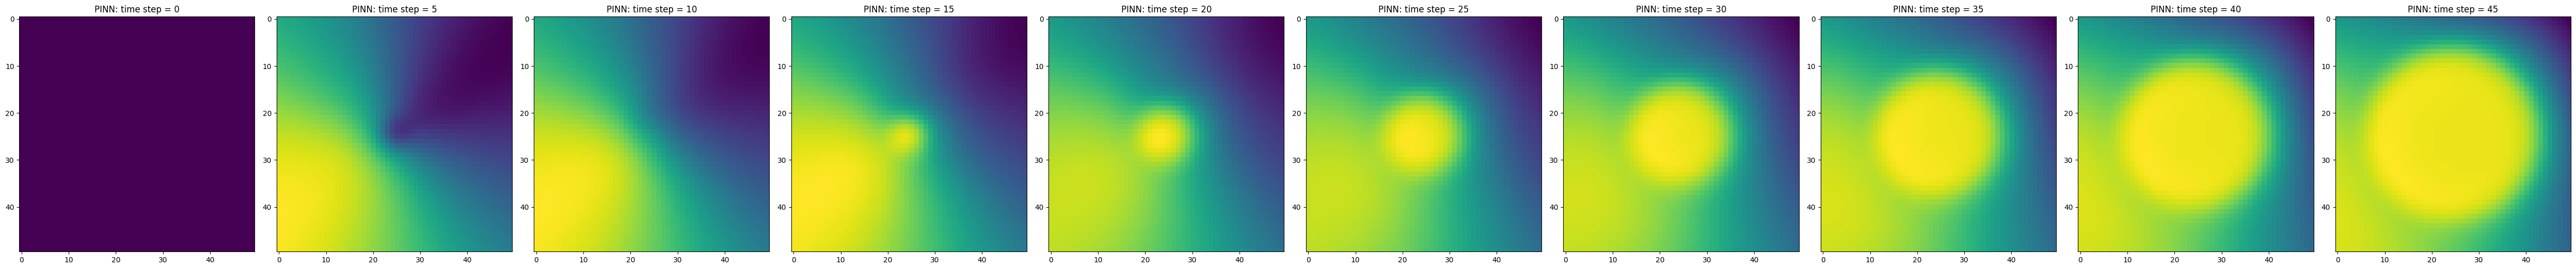

Finished training


In [72]:
trainer.train()

In [73]:
from fbpinns.active_schedulers import AllActiveSchedulerND
A, args = AllActiveSchedulerND, ()
width = .9
n_hidden, n_layers = 64, 3
n_subdomains = 4
subdomain_xs = [np.linspace(-1,1,n_subdomains), np.linspace(-1,1,n_subdomains), np.linspace(0,1,n_subdomains)]
subdomain_ws = get_subdomain_ws(subdomain_xs, width)
subdomain_xs

[array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 array([-1.        , -0.33333333,  0.33333333,  1.        ]),
 array([0.        , 0.33333333, 0.66666667, 1.        ])]

In [74]:
cfbpinn = Constants(
              RUN="final_FBPINN_%s_%sh_%sl_%sb_%s_%sw_%s"%(P.name, n_hidden, n_layers, batch_size[0], sampler, width, A.name),
              P=P,
              SUBDOMAIN_XS=subdomain_xs,
              SUBDOMAIN_WS=subdomain_ws,
              BOUNDARY_N=boundary_n,
              Y_N=y_n,
              ACTIVE_SCHEDULER=A,
              ACTIVE_SCHEDULER_ARGS=args,
              N_HIDDEN=n_hidden,
              N_LAYERS=n_layers,
              BATCH_SIZE=batch_size,
              RANDOM=random,
              N_STEPS=n_steps,
              BATCH_SIZE_TEST=batch_size_test,
              PLOT_LIMS=plot_lims,
              )

2024-06-07 14:02:32,291 [fbpinns.trainers_base] INFO: RUN: final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All
P: <__main__.WaveEquation3D object at 0x70783e434090>
SUBDOMAIN_XS: [array([-1.        , -0.33333333,  0.33333333,  1.        ]), array([-1.        , -0.33333333,  0.33333333,  1.        ]), array([0.        , 0.33333333, 0.66666667, 1.        ])]
SUBDOMAIN_WS: [array([0.6, 0.6, 0.6, 0.6]), array([0.6, 0.6, 0.6, 0.6]), array([0.3, 0.3, 0.3, 0.3])]
BOUNDARY_N: (0.1,)
Y_N: (0, 1)
ACTIVE_SCHEDULER: <class 'fbpinns.active_schedulers.AllActiveSchedulerND'>
ACTIVE_SCHEDULER_ARGS: ()
DEVICE: 0
MODEL: <class 'fbpinns.models.FCN'>
N_HIDDEN: 64
N_LAYERS: 3
BATCH_SIZE: (50, 50, 30)
RANDOM: True
LRATE: 0.001
N_STEPS: 10000
SEED: 123
BATCH_SIZE_TEST: (50, 50, 50)
PLOT_LIMS: (5.0, True)
SUMMARY_FREQ: 250
TEST_FREQ: 1000
MODEL_SAVE_FREQ: 10000
SHOW_FIGURES: True
SAVE_FIGURES: False
CLEAR_OUTPUT: False
SUMMARY_OUT_DIR: results/summaries/final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m

0 Active updated:
 [[[1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]]

 [[1 1 1]
  [1 1 1]
  [1 1 1]]]
[i: 250/10000] loss: 4.5843 rate: 2.3 elapsed: 0.03 hr 2024-06-07 13:04:21 final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All
[i: 500/10000] loss: 2.7836 rate: 2.3 elapsed: 0.06 hr 2024-06-07 13:06:11 final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All
[i: 750/10000] loss: 0.8735 rate: 2.3 elapsed: 0.09 hr 2024-06-07 13:07:59 final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All
[i: 1000/10000] loss: 0.5300 rate: 2.3 elapsed: 0.12 hr 2024-06-07 13:09:48 final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All


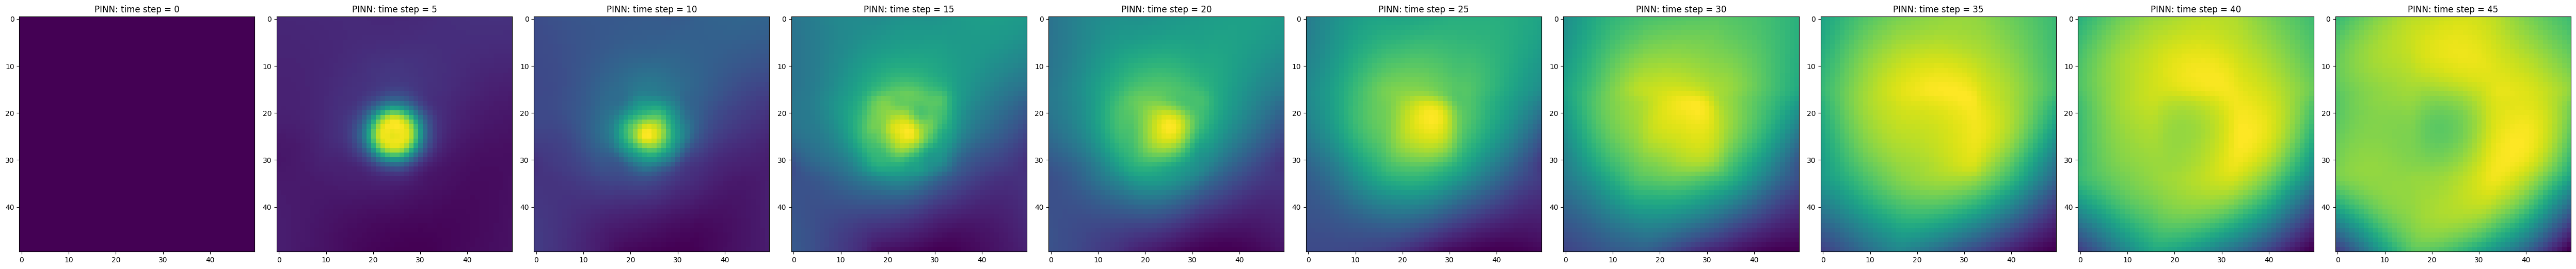

[i: 1250/10000] loss: 0.2889 rate: 2.3 elapsed: 0.15 hr 2024-06-07 13:11:38 final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All
[i: 1500/10000] loss: 0.1961 rate: 2.3 elapsed: 0.18 hr 2024-06-07 13:13:26 final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All
[i: 1750/10000] loss: 0.3140 rate: 2.3 elapsed: 0.21 hr 2024-06-07 13:15:16 final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All
[i: 2000/10000] loss: 0.1198 rate: 2.3 elapsed: 0.24 hr 2024-06-07 13:17:06 final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All


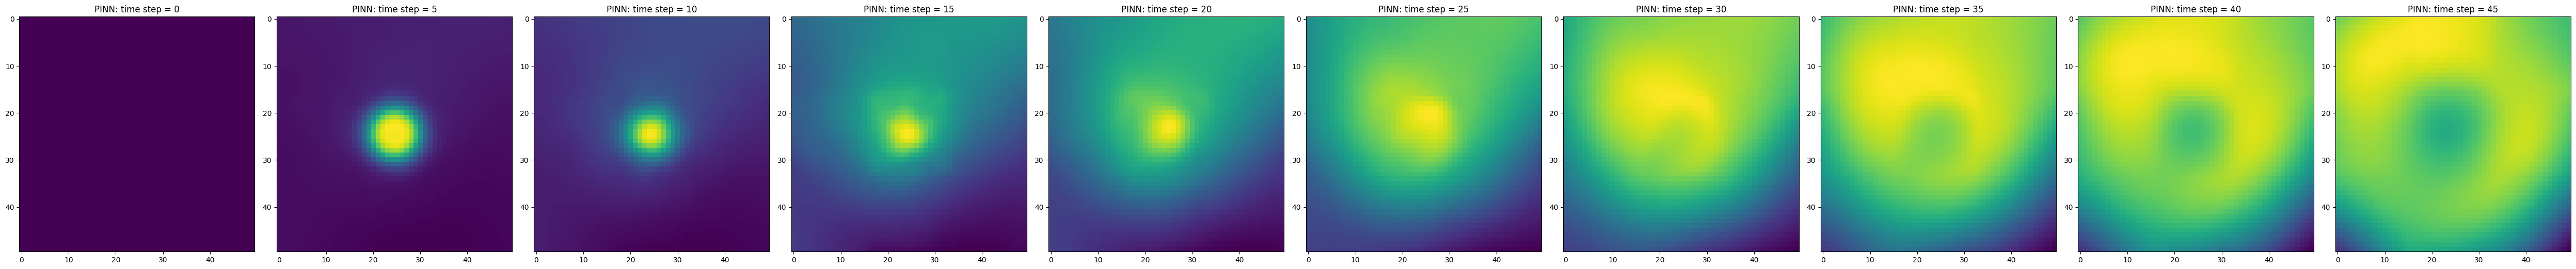

[i: 2250/10000] loss: 0.0804 rate: 2.3 elapsed: 0.27 hr 2024-06-07 13:18:57 final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All
[i: 2500/10000] loss: 0.0911 rate: 2.3 elapsed: 0.30 hr 2024-06-07 13:20:48 final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All
[i: 2750/10000] loss: 0.1136 rate: 2.2 elapsed: 0.34 hr 2024-06-07 13:22:39 final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All
[i: 3000/10000] loss: 0.0515 rate: 2.1 elapsed: 0.37 hr 2024-06-07 13:24:37 final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All


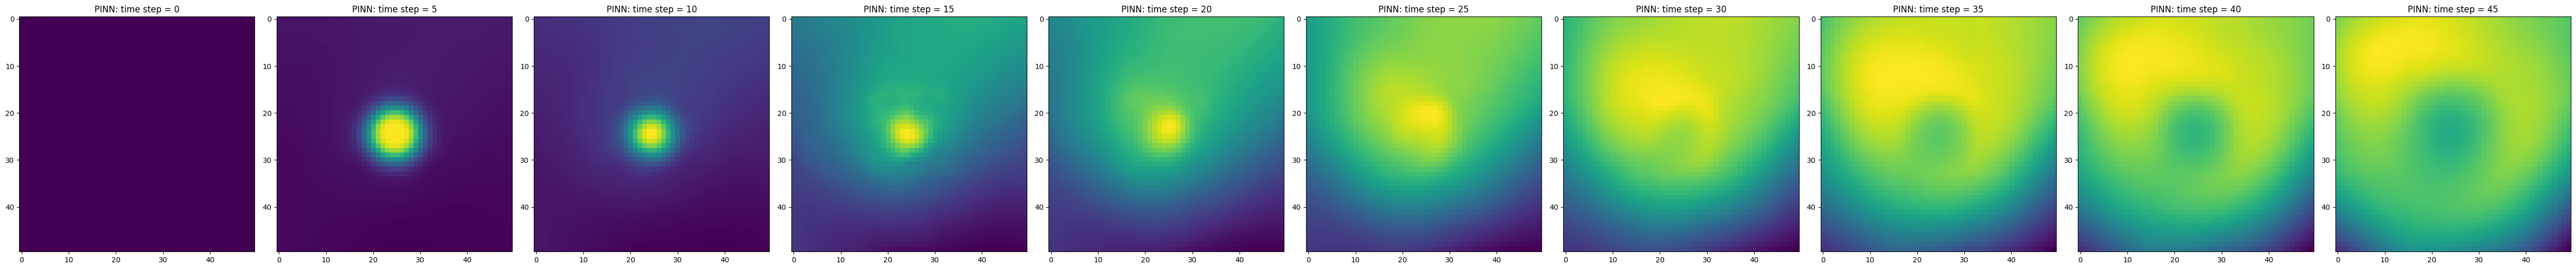

[i: 3250/10000] loss: 0.0448 rate: 2.2 elapsed: 0.40 hr 2024-06-07 13:26:33 final_FBPINN_WaveEquation3D_s0.1c1.0_64h_3l_50b_m_0.9w_All


KeyboardInterrupt: 

In [75]:
from fbpinns.trainers.fbpinn_trainer import FBPINNTrainer
cfbpinn.TEST_FREQ = 1000
cfbpinn.N_STEPS = 10000
fbtrainer = FBPINNTrainer(c=cfbpinn)
fbtrainer.train()